# Using MITGCM data

In this example we will generate structure functions from MITgcm ECCO data. 

**General procedure:**

1. Load data
2. Format data
3. Calculate structure functions
4. Plot structure functions

We are using one snapshot of velocity fields from the [Southern Ocean Pre-SWOT Level-4 Hourly MITgcm LLC4320 Native Grid 2km Oceanographic Dataset Version 1.0](https://podaac.jpl.nasa.gov/dataset/MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0). The file is not provided in the FluidSF repository but can be accessed through the above link using the [PO.DAAC Data Subscriber](https://github.com/podaac/data-subscriber).

**Note: this example demonstrates how FluidSF supports nonuniform latitude-longitude grids. This functionality is still in development so the authors advise some caution when using this example. The authors also welcome any comments/feedback to improve the functionality.**

In [1]:
import warnings

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import xarray as xr

import fluidsf

warnings.filterwarnings("ignore")  # Ignore warnings for the purpose of this tutorial

sns.set_style(style="white")
sns.set_context("talk")
matplotlib_inline.backend_inline.set_matplotlib_formats("png", dpi=200)

## Load the dataset

Here we will use [xarray](https://xarray.dev) to load in the NetCDF file we downloaded through the links above. We will select the first snapshot `time=0` and the ocean surface `k=0`.

In [2]:
ds = xr.open_dataset("path/to/data/file.nc")
ds = ds.isel(time=0, k=0)

## Visualize the velocity fields

Here we are plotting the U and V velocities which are in the +x and +y directions in the model. These are not the east-west and north-south velocities. 

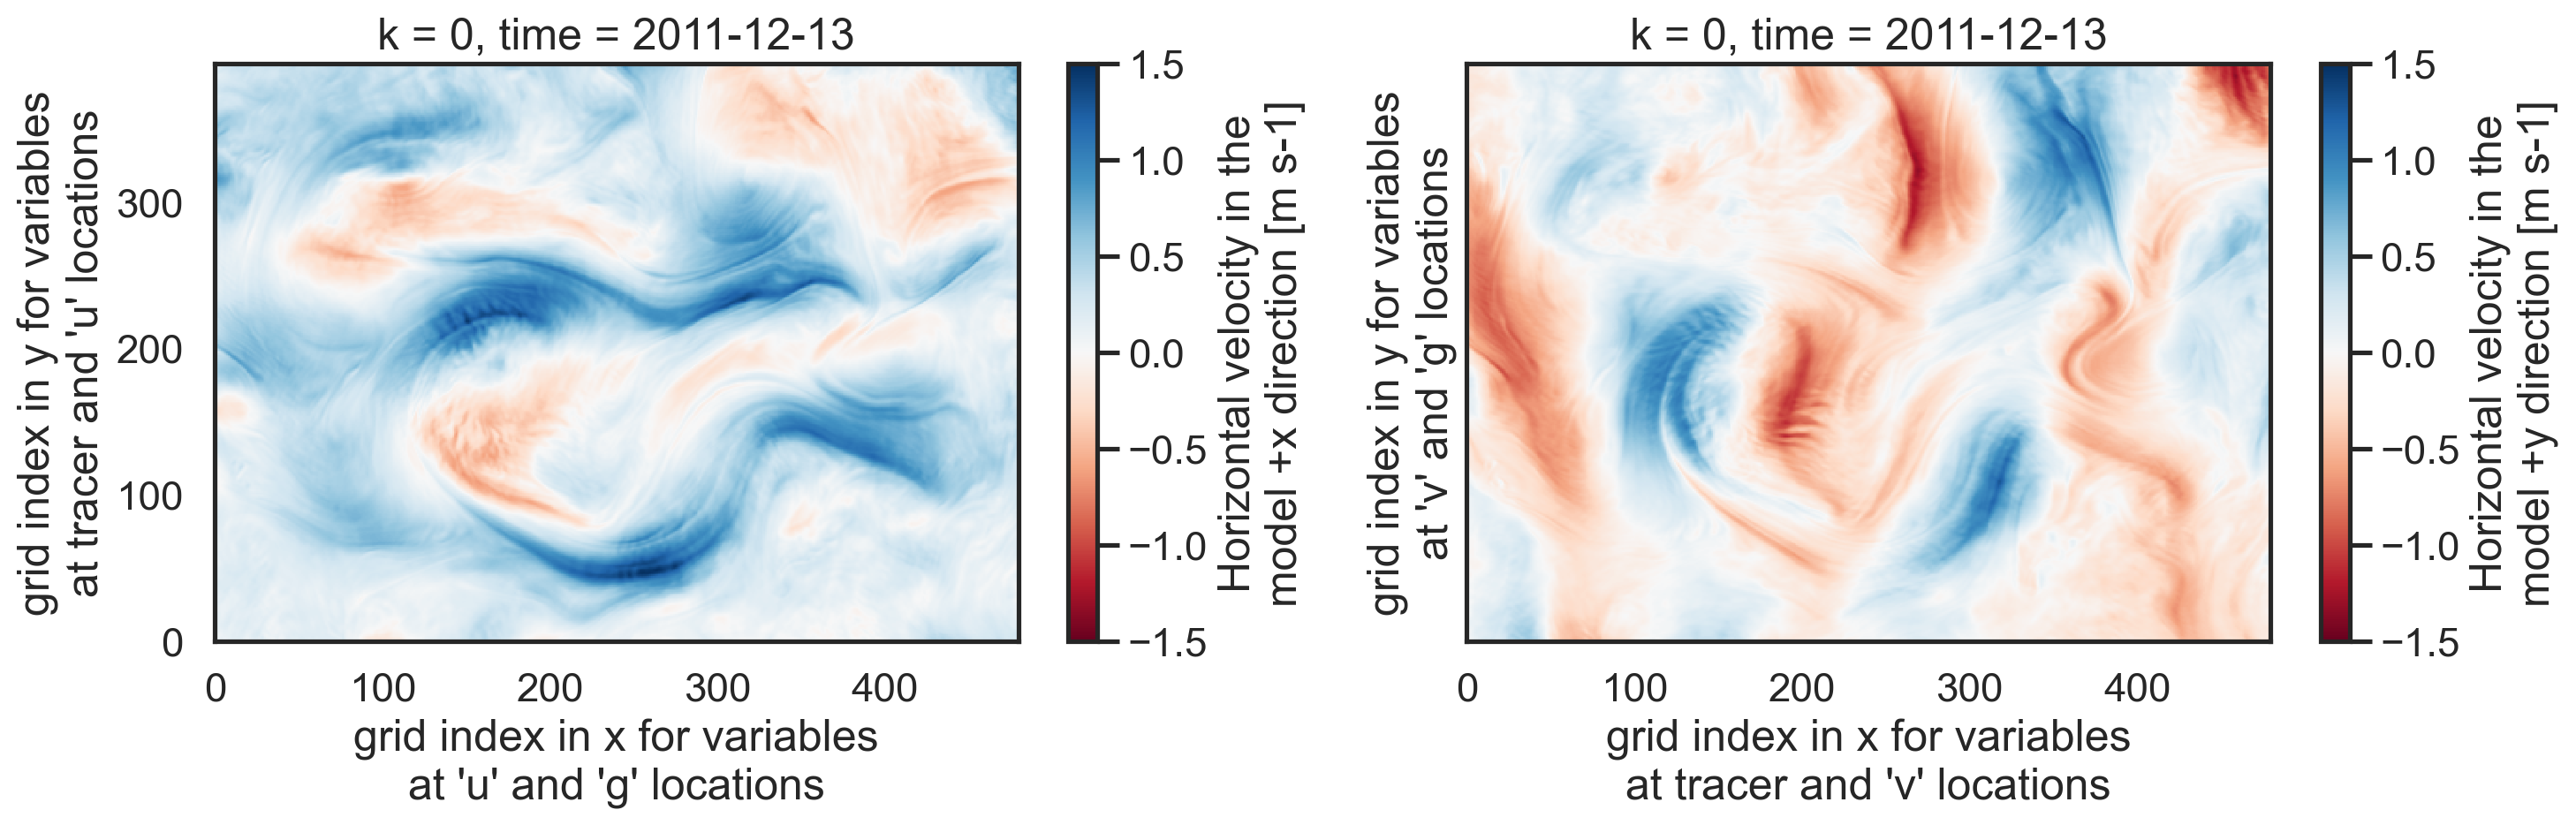

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

ds.U.plot.pcolormesh(ax=ax[0], cmap="RdBu", vmin=-1.5, vmax=1.5)
ds.V.plot.pcolormesh(ax=ax[1], cmap="RdBu", vmin=-1.5, vmax=1.5)

plt.tight_layout()

## Convert velocities to east-west and north-south

We need the east-west and north-south velocity components if we plan to use the `latlon` grid type in FluidSF. If we use U and V without converting them, FluidSF will assume these are the true east-west and north-south velocity components.

In [4]:
U_east = ds.AngleCS.values * ds.U.values - ds.AngleSN.values * ds.V.values
V_north = ds.AngleSN.values * ds.U.values + ds.AngleCS.values * ds.V.values

ds["U_east"] = xr.DataArray(U_east, dims=["j", "i"], coords={"j": ds.j, "i": ds.i})
ds["V_north"] = xr.DataArray(V_north, dims=["j", "i"], coords={"j": ds.j, "i": ds.i})

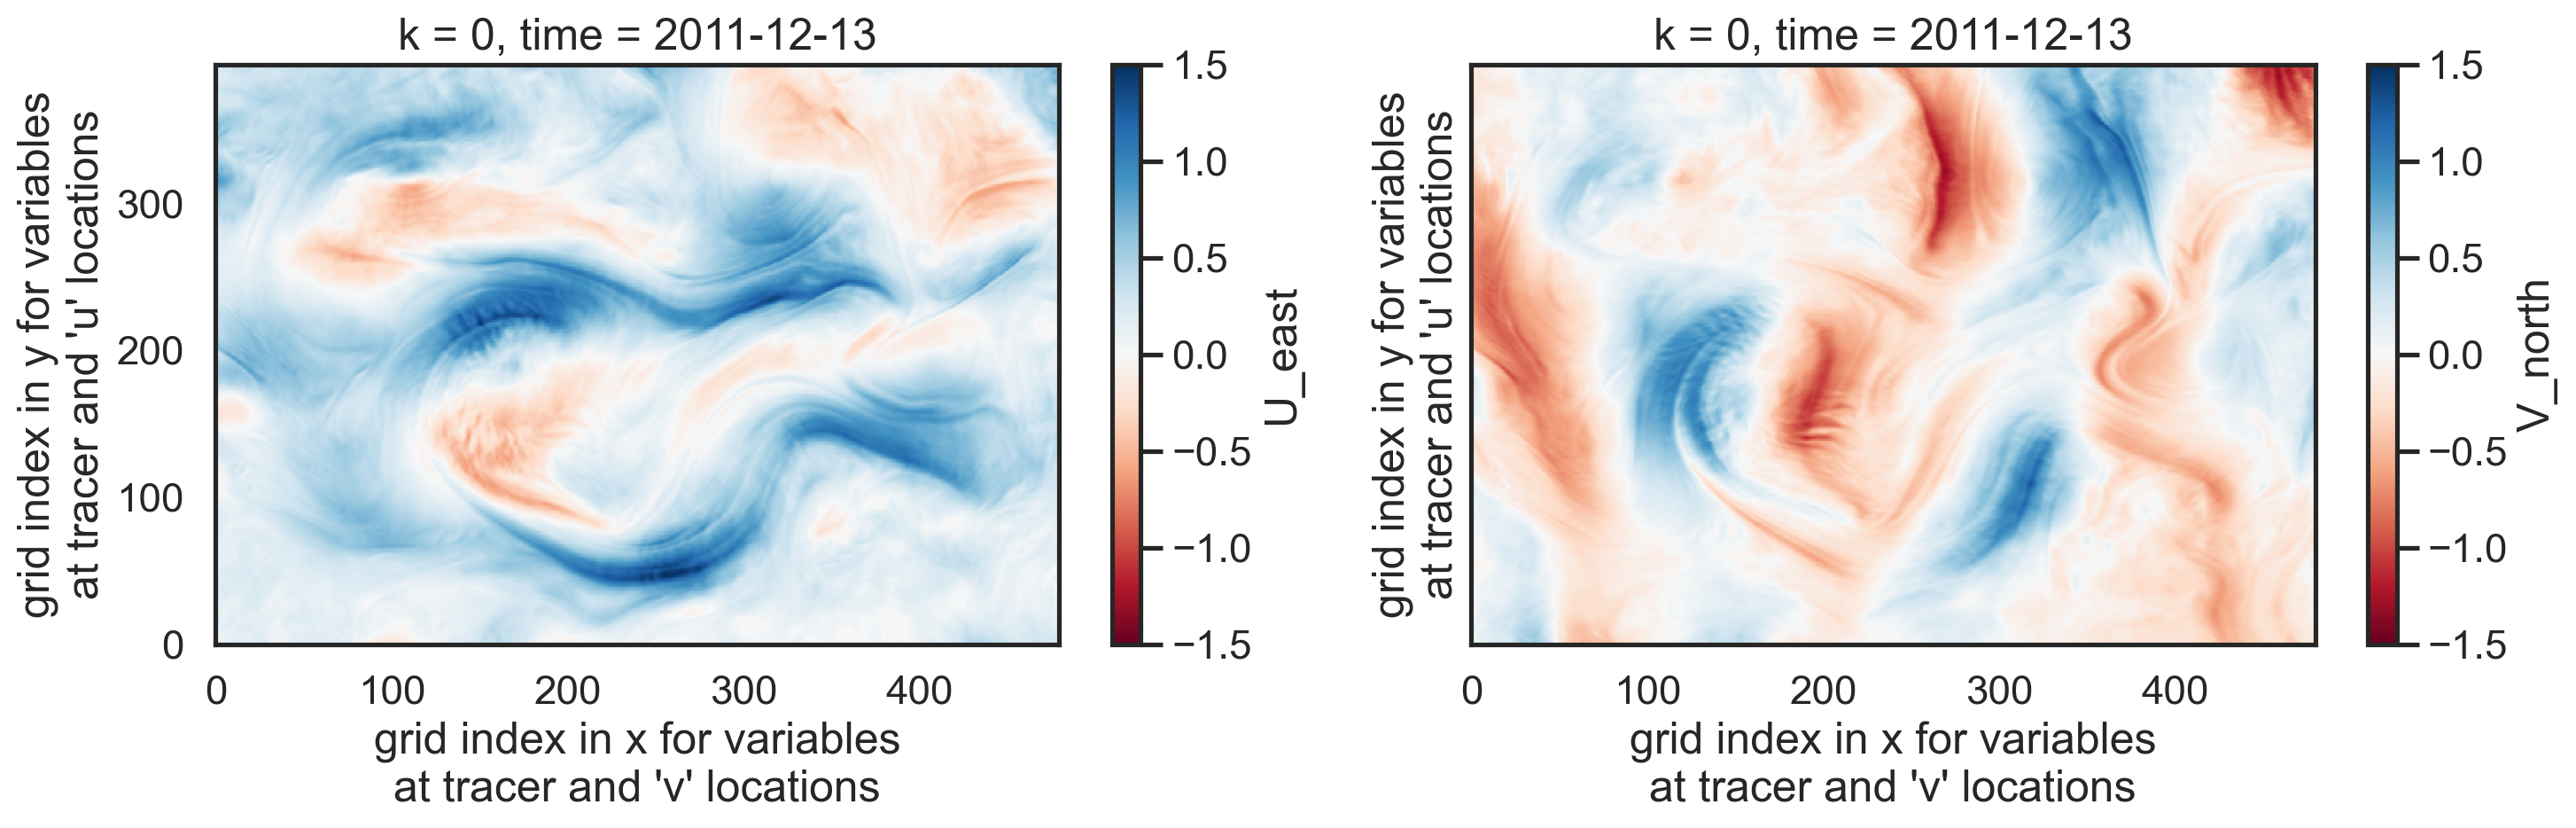

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

ds.U_east.plot.pcolormesh(ax=ax[0], cmap="RdBu", vmin=-1.5, vmax=1.5)
ds.V_north.plot.pcolormesh(ax=ax[1], cmap="RdBu", vmin=-1.5, vmax=1.5)

plt.tight_layout()

`U`/`V` and `U_east`/`V_north` are similar, but not exactly the same. Using `U`/`V` instead of `U_east`/`V_north` won't have a substantial impact on the structure function calculations in this example, but this is worth keeping in mind with other datasets if you need to convert vectors to meridional/zonal components.

## Generate structure functions

We will provide the meridional and zonal velocity components for velocities as `u=ds.U_east` and `v=ds.V_north` as well as latitudes/longitudes as `lats=ds.YC` and `lons=ds.XC`. We'll add `.values` to convert the xarray data arrays into NumPy arrays, dropping any metadata. 

We'll calculate the advective velocity structure function (`ASF_V`). Boundary conditions are set to `None`, the grid type is `latlon` and we specify a bin number `nbins=100`. You can adjust the bin number however you see fit.

In [6]:
sf = fluidsf.generate_structure_functions(
    u=ds.U_east.values,
    v=ds.V_north.values,
    lats=ds.YC.values,
    lons=ds.XC.values,
    sf_type=["ASF_V"],
    boundary=None,
    grid_type="latlon",
    nbins=100,
)

## Plot the results

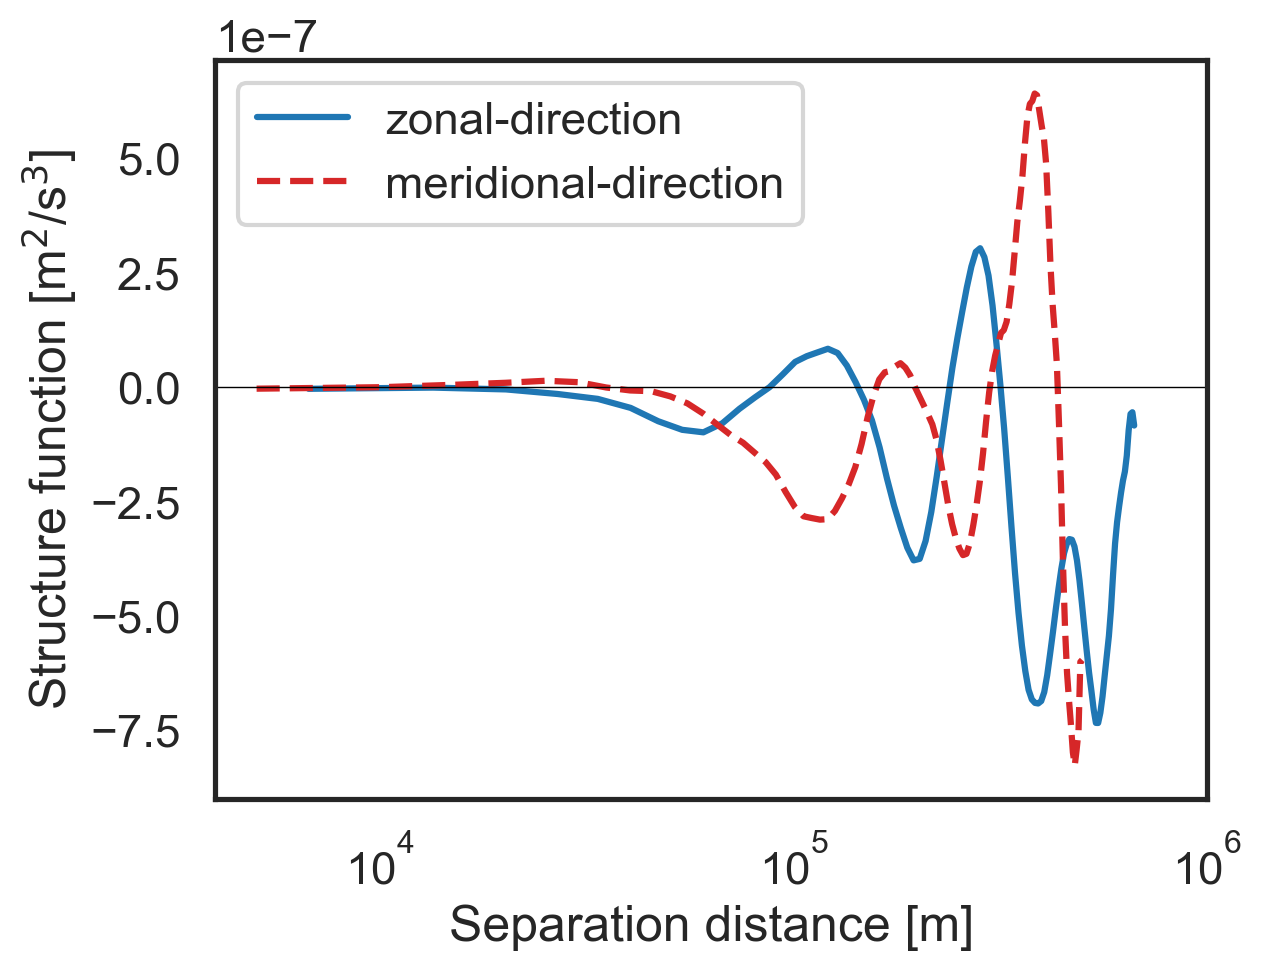

In [7]:
plt.semilogx(
    sf["x-diffs"],
    sf["SF_advection_velocity_x"],
    color="tab:blue",
    label="zonal-direction",
)
plt.semilogx(
    sf["y-diffs"],
    sf["SF_advection_velocity_y"],
    color="tab:red",
    linestyle="--",
    label="meridional-direction",
)

plt.xlabel("Separation distance [m]")
plt.ylabel("Structure function [m$^2$/s$^3$]")
plt.xlim(4e3, 1e6)
plt.hlines(0, 1e3, 1e6, color="black", lw=0.5)
plt.legend();